## Setup


In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

In [3]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 1, 2, 5, 2, 7, 4, 0])


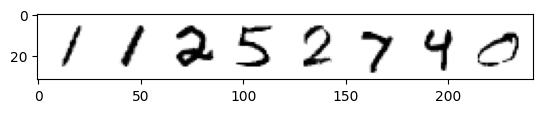

In [4]:
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

### The Corruption Process (Add Noise)

In [5]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`."""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # sort shape so that it can be broadcasted
    return x * (1 - amount) + noise * amount

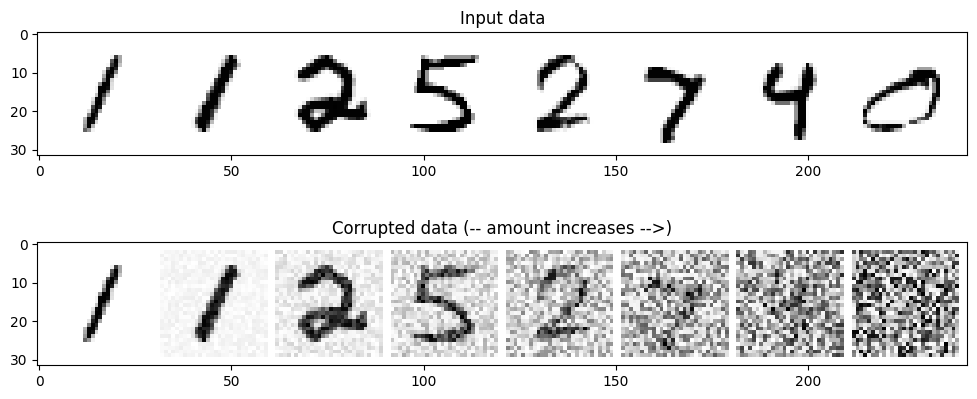

In [6]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

## Model Setup (UNet)

*UNet Archtitecture*:

![UNet Architecture](./assets/unet.png)

In [7]:
class BasicUNet(nn.Module):
    """A minimal UNet Implementation."""
    
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU() # activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)
        
    def forward(self, x):
        h = []
        
        # Downward path (encoding)
        for i, layer in enumerate(self.down_layers):
            x = self.act(layer(x))              # forward pass through the layer and activation
            if i < len(self.down_layers) - 1:   # for all layers except the last
                h.append(x)                     # store the intermediate result for the skip connection
                x = self.downscale(x)           # downscale the feature map
                
        # Upward path (decoding)
        for i, layer in enumerate(self.up_layers):
            if i > 0:                           # for all layers except the first
                x = self.upscale(x)             # upscale the feature map
                x += h.pop()                     # add the skip connection
            x = self.act(layer(x))              # forward pass through the layer and activation
            
        return x

In [8]:
# test model with same as mnist input and output
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [9]:
# see total number of parameters
sum([p.numel() for p in net.parameters()])

309057

## Training the Model

Flow:
- Get a batch of data
- Corrupt it by random amounts
- Feed forward through the model
- Compare the model predictions with the clean images to calculate the loss
- Update the model's parameters accordingly

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.8/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/25 - Loss: 0.0243
Epoch 2/25 - Loss: 0.0188
Epoch 3/25 - Loss: 0.0174
Epoch 4/25 - Loss: 0.0168
Epoch 5/25 - Loss: 0.0161
Epoch 6/25 - Loss: 0.0157
Epoch 7/25 - Loss: 0.0149
Epoch 8/25 - Loss: 0.0142
Epoch 9/25 - Loss: 0.0140
Epoch 10/25 - Loss: 0.0137
Epoch 11/25 - Loss: 0.0135
Epoch 12/25 - Loss: 0.0133
Epoch 13/25 - Loss: 0.0132
Epoch 14/25 - Loss: 0.0129
Epoch 15/25 - Loss: 0.0131
Epoch 16/25 - Loss: 0.0128
Epoch 17/25 - Loss: 0.0127
Epoch 18/25 - Loss: 0.0127
Epoch 19/25 - Loss: 0.0127
Epoch 20/25 - Loss: 0.0126
Epoch 21/25 - Loss: 0.0125
Epoch 22/25 - Loss: 0.0125
Epoch 23/25 - Loss: 0.0124
Epoch 24/25 - Loss: 0.0123
Epoch 25/25 - Loss: 0.0123


(0.0, 0.1)

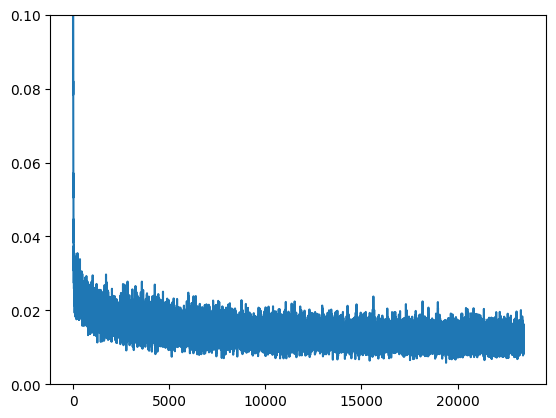

In [10]:
# dataloader
batch_size = 64
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 25

# model
net = BasicUNet().to(device)

# loss function
loss_fn = nn.MSELoss()
losses = []

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# training loop
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        
        # get the data and prepare the corrupted version
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)
        
        # forward pass
        pred = net(noisy_x)
        
        # compute the loss
        loss = loss_fn(pred, x) # how close is the output to the the true 'clean' x?
        
        # backpropagation and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # store the loss
        losses.append(loss.item())
        
    # print the loss every epoch
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}")
    
# plot the loss
plt.plot(losses)
plt.ylim(0, 0.1)

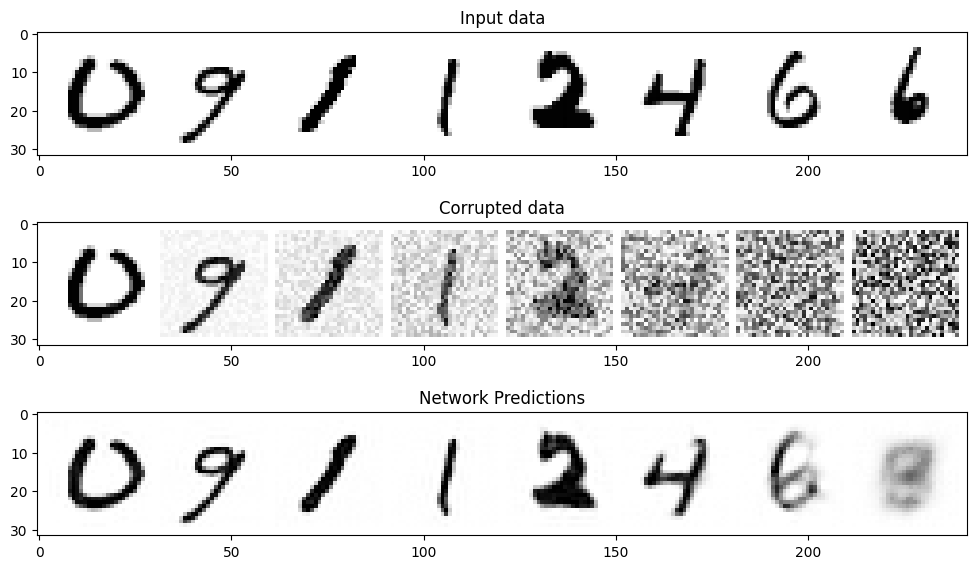

In [11]:
# Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

## Inference

The model that was we trained are different from the DDPM model. The DDPM model is **trained to predict the noise**, while the UNet model is **trained to predict the clean image from the noisy image**. 

In the example of our predictions at high noise level, the result is not good. Because it's only **one step of the process**. Unlike the DDPM model, that **denoise the image by multiple steps**.

So, the inference process is:
- Start with a noisy image
- Feed forward through the model
- **Mix** the model's predictions with the noisy image according the **mix factor**
- Repeat the process until N steps

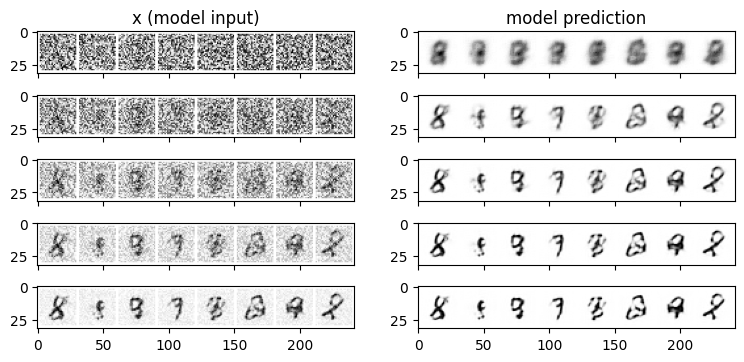

In [12]:
# Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:

n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = net(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")

for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")

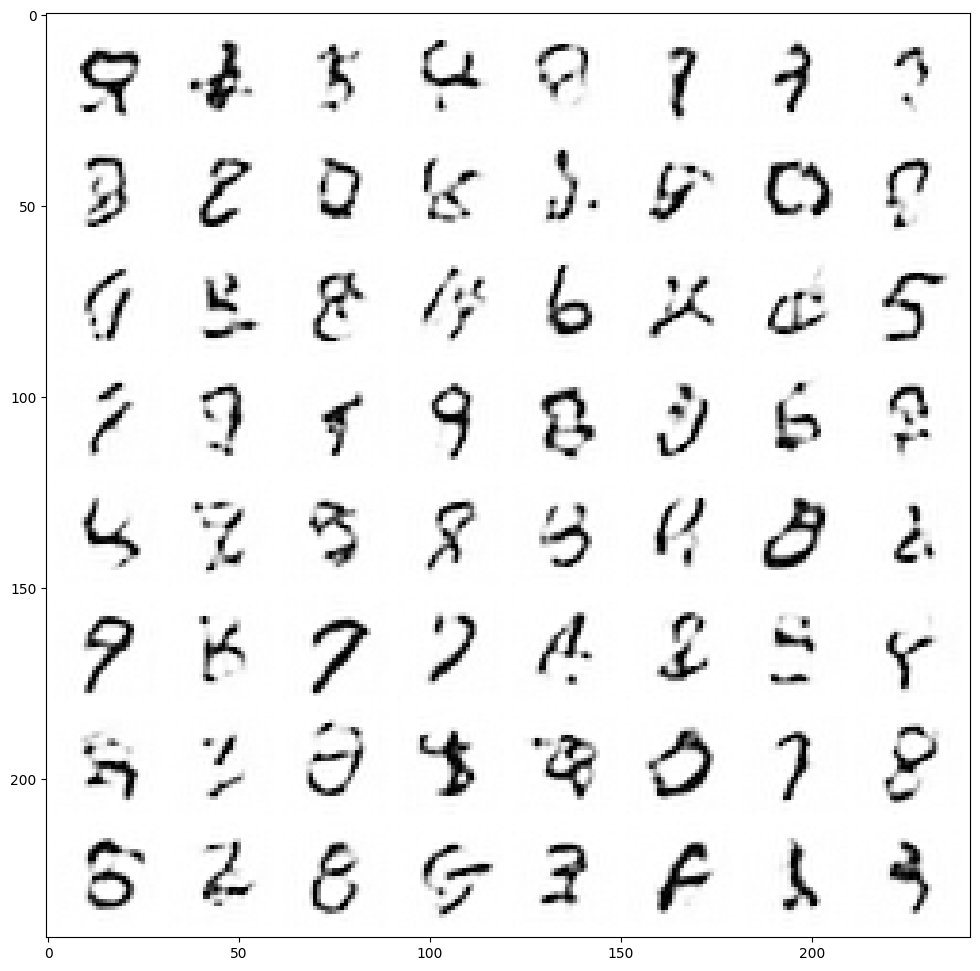

In [13]:
def inference(model, x, n_steps):
    """
    UNet Diffusion Inference.
    ---
    model: torch.nn.Module
        The model to perform inference with.
    x: torch.Tensor
        The input tensor (random noise) to perform inference on.
    n_steps: int
        The number of steps to perform.
    """
    for i in range(n_steps):
        with torch.no_grad():
            pred = model(x)
        mix_factor = 1 / (n_steps - i)
        x = x * (1 - mix_factor) + pred * mix_factor
        
    return x

# Test the inference function
x_in = torch.rand(64, 1, 28, 28).to(device)
x_out = inference(net, x_in, n_steps=5)

# Plot the input and output
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x_out.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys")

## Conclusion

- **Training Objective**:
  - The DDPM model is trained to **predict the noise**.
  - The Loss is calculated by **comparing** the **predicted noise** with the **actual noise**.
  - Choosing the training objective is important to get the best result (Predict the noise or Predict the clean image).
  - The noise predition currently is the general approach for denoising task.
- **Timestep Conditioning**:
  - Model (like UNet2DModel) take both the image and timestep as input.
  - The timestep is **converted to embedding** and fed into the model to **help it understand the current noise level**.
  - Timestep conditioning imporves model perfomance, although models can theoretically be trained without it.
- **Sampling (Image Generation Proess**:
  - To generate new images, the model starts from pure noise and iteratively reduces the noise in small steps.
  - Methods:
    - **Noise schedule**: Determines the size of the steps taken.
    - **Predition methods**: Using model's current prediction.
    - **Stochasticity**: Adding randomness to the process.